In [1]:
#install all dependencies
!pip3 install simple-tensor
!pip3 install opencv-python
!pip3 install comdutils
!pip3 uninstall tensorflow-gpu
!pip3 install tensorflow-gpu==1.15.0

     |████████████████████████████████| 51kB 2.1MB/s 
  Created wheel for simple-tensor: filename=simple_tensor-0.7.14-cp36-none-any.whl size=50840 sha256=d55f65cb728dc711008617dd11286f549bed2152681ddd091d632efbc6b8a5cd
  Stored in directory: /root/.cache/pip/wheels/c2/13/0c/be211db1c202df1c18498f5036a26449f182f6a096f093eb58
Successfully built simple-tensor
  Created wheel for comdutils: filename=comdutils-0.3.5-cp36-none-any.whl size=5222 sha256=7d75b27ae226fa0a5f0c9dc82a39dd22549fc6c965a29ca35330ed878e0d90b4
  Stored in directory: /root/.cache/pip/wheels/18/2b/82/f8681e425164b99fe7048ee4a72a7b63245c9a4375df2c5d2b
Successfully built comdutils
     |████████████████████████████████| 411.5MB 42kB/s 
     |████████████████████████████████| 3.8MB 38.6MB/s 
     |████████████████████████████████| 512kB 38.0MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f1c67eb4308b5d4932e9d8188733d7d0f1cdf3deca7cf

In [35]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# import our dependencies
import tensorflow as tf
from simple_tensor.tensor_losses import softmax_crosentropy_mean
from simple_tensor.transfer_learning.image_recognition import *

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [4]:
# ----------------------------------------- #
# Build simple tensor wrapper for image recognition
# there are 3 classes separated by folder "kelapa", "kurma", "lontar"
#
#
# folder structure:
# -dataset
# -    - train
# -    -     - kelapa
# -    -     - kurma
# -    -     - lontar
# -    - val
# -    -     - kelapa
# -    -     - kurma
# -    -     - lontar
#
#
# input image designed 300x300 in size
# with three channels            
# ----------------------------------------- #
imrec = ImageRecognition(classes=['kelapa', 'kurma', 'lontar'],
                         input_height = 300,
                         input_width = 300, 
                         input_channel = 3)

In [5]:
# ----------------------------------------- #
# build neural network graph
# we are using densenet 121 base architecture
# ----------------------------------------- #
out, var_list = imrec.build_densenet_base(imrec.input_placeholder,
                                    dropout_rate = 0.20,
                                    is_training = True,
                                    top_layer_depth = 128)

# ----------------------------------------- #
# calculate the loss
# softmax cross entropy loss
# update ops for TF batch normalization
# ----------------------------------------- #
cost = softmax_crosentropy_mean(out, imrec.output_placeholder)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# ----------------------------------------- #
# Build TF saver for loading and saving model    
# Build TF session for running the operations
#
# saver_all : save/restore all variable in neural net
# saver_partial: save partial variable 
# ----------------------------------------- #
saver_partial = tf.train.Saver(var_list)
saver_all = tf.train.Saver()
session = tf.Session()
session.run(tf.global_variables_initializer())

# Note, we will use transfer learning
# So, for the first training we will load pretrained model partially
# why ....? cause we modify the architecture 
saver_partial.restore(sess=session, save_path='/content/gdrive/My Drive/model/densenet-121/tf-densenet121.ckpt')


# for the next training use this
# restore all previously trained model variable
#saver_partial.restore(sess=session, save_path='/content/gdrive/My Drive/tutorial/model')

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/model/densenet-121/tf-densenet121.ckpt


In [8]:
# ----------------------------------------- #
# Create batch generator for train and val
# ----------------------------------------- #
train_generator = imrec.batch_generator(batch_size=24, 
                                        dataset_path='/content/gdrive/My Drive/dataset/intro-classification/train/', 
                                        message="TRAIN")
val_generator = imrec.batch_generator(batch_size=36, 
                                        dataset_path='/content/gdrive/My Drive/dataset/intro-classification/val/', 
                                        message="VAL")

In [9]:
# ----------------------------------------- #
# start training
# iteration : num of iterartion
# subdivition: subdivition per iteration
# path_tosave_model: path to save model
# ----------------------------------------- #
imrec.optimize(iteration=2000, 
         subdivition=5,
         cost_tensor=cost,
         optimizer_tensor=optimizer,
         out_tensor = out,
         session = session, 
         saver = saver_all,
         train_generator = train_generator,
         val_generator = val_generator,
         best_loss = 10000,
         path_tosave_model='/content/gdrive/My Drive/tutorial/model')

------------------------INFO IMAGES-------------------
Image Folder: /content/gdrive/My Drive/dataset/intro-classification/train/
Number of Image in kelapa:  126
Number of Image in kurma:  128
Number of Image in lontar:  101
------------------------------------------------------
> Train sub 0 loss :  0.9766474
> Train sub 1 loss :  1.0319374
> Train sub 2 loss :  1.0306579
> Train sub 3 loss :  1.0662103
> Train sub 4 loss :  1.0194892
------------------------INFO IMAGES-------------------
Image Folder: /content/gdrive/My Drive/dataset/intro-classification/val/
Number of Image in kelapa:  12
Number of Image in kurma:  12
Number of Image in lontar:  13
------------------------------------------------------
>> epoch:  0 train loss:  1.025 val loss:  1.084 val acc:  0.444 ************* model saved
> Train sub 0 loss :  1.0181137
> Train sub 1 loss :  1.0221598
> Train sub 2 loss :  0.9936392
> Train sub 3 loss :  0.999502
> Train sub 4 loss :  0.9819073
==>>> INFO: your VAL in class kelap

KeyboardInterrupt: ignored

In [10]:
# see the validation image
x_img, y_img = next(val_generator)

==>>> INFO: your VAL in class kelapa dataset is reshuffled again 12
==>>> INFO: your VAL in class kurma dataset is reshuffled again 12
==>>> INFO: your VAL in class lontar dataset is reshuffled again 13


In [12]:
# print the shape of validation image
# nilai pertama -> jumlah batch gamabar
# nilai kedua -> tinggi gamabar
# nilai ketiga -> lebar gamabr
# nilai keempat -> channel gambar
print(x_img.shape)

(36, 300, 300, 3)


In [13]:
# install matplotlib untuk visualisasi gamabr
!pip3 install matplotlib

In [14]:
#
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show>

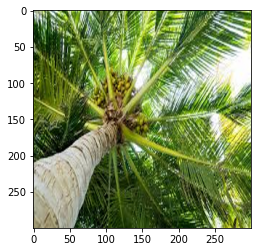

In [22]:
# visualisasi gambar validasi dari image ke i
plt.imshow(x_img[3])
plt.show

In [16]:
# mencoba memprediksi hasil validasi dari neural network
# caranya,
# create feed dictionary
# set the image to the TF mouth (placeholder)
feed_dict = {}
feed_dict[imrec.input_placeholder] = x_img
val_output = session.run(out, feed_dict=feed_dict)

In [18]:
# print shape output
# dimensi pertama jumlah batch
# dimensi kedua probabilitas masing2 kelas
print (val_output.shape)

(36, 3)


In [23]:
# print hasil prediksi untuk batch ke i
print (val_output[3])

[9.9868578e-01 5.3954101e-04 7.7465957e-04]


In [37]:
# predik dari gambar tunggal
img = cv2.imread('/content/gdrive/My Drive/tutorial/mfm/images.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

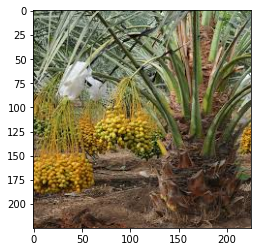

In [25]:
plt.imshow(img)
plt.show()

In [26]:
print (img.shape)

(225, 225, 3)


In [27]:
# resize the image to 300x300
img2 = cv2.resize(img, (300, 300))
print (img2.shape)

(300, 300, 3)


In [30]:
img2 = img2.reshape((1, 300, 300, 3))
img2 = img2.astype(np.float32)/255.
print (img2.shape)

(1, 300, 300, 3)


In [31]:
# mencoba memprediksi hasil validasi dari neural network
# caranya,
# create feed dictionary
# set the image to the TF mouth (placeholder)
feed_dict = {}
feed_dict[imrec.input_placeholder] = img2
val_output = session.run(out, feed_dict=feed_dict)

In [32]:
print (val_output.shape)

(1, 3)


In [33]:
print (val_output)

[[0.33508444 0.33213046 0.3327851 ]]
